In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D , Dropout
from tensorflow.keras.utils import to_categorical

In [5]:
train = pd.read_csv("/content/drive/MyDrive/112x112_2k_deepfake_images.csv").values

test  = pd.read_csv("/content/drive/MyDrive/112x112_600_validation_deepfake_images.csv").values


trainX = train[:, :-1].reshape(train.shape[0],112, 112, 1).astype( 'float32' )
X_train = trainX / 255.0

y_train = train[:,-1]


# Reshape and normalize test data
testX = test[:,:-1].reshape(test.shape[0],112, 112, 1).astype( 'float32' )
X_test = testX / 255.0

y_test = test[:,-1]


In [6]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [7]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

def mbConv_block(
    input_data,repeat_num, kernel_size,input_filter,output_filter,expand_ratio,se_ratio,strides, drop_ratio):


    # expansion phase (1,1)
    expanded_filter =  input_filter * expand_ratio
    x = tf.keras.layers.Conv2D(expanded_filter, 1,  padding='same',  use_bias=False)(input_data)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # Depthwise convolution phase (k,k)
    x = tf.keras.layers.DepthwiseConv2D(kernel_size, strides,  padding='same',  use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # Squeeze and excitation phase (1,1)
    squeezed_filter = max(1, int(input_filter * se_ratio))
    se = tf.keras.layers.GlobalAveragePooling2D()(x)
    se = tf.keras.layers.Reshape((1, 1, expanded_filter))(se)
    se = tf.keras.layers.Conv2D(squeezed_filter,1)(se)
    se = tf.keras.layers.Activation('swish')(se)
    se = tf.keras.layers.Conv2D(expanded_filter,1, activation='sigmoid')(se)
    x = tf.keras.layers.multiply([x, se])

    # Output phase (1,1)
    x = tf.keras.layers.Conv2D(output_filter, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if repeat_num == 1:
        pass
    else:
        x = tf.keras.layers.Dropout(drop_ratio)(x)

    return x


def Model():

    model_input =  tf.keras.layers.Input(shape = (112,112,1))

    # stem
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same',strides = (2,2))(model_input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # mbConv_blocks
    MBConv1_1 = mbConv_block(x,3,1,32,16,1,0.25,1,0.2)

    MBConv6_2_1 = mbConv_block(MBConv1_1,3,1,16,24,6,0.25,2,0.2)
    MBConv6_2_2 = mbConv_block(MBConv1_1,3,2,16,24,6,0.25,2,0.2)
    x = tf.keras.layers.add([MBConv6_2_1, MBConv6_2_2])

    MBConv6_3_1 = mbConv_block(x,5,1,24,40,6,0.25,2,0.2)
    MBConv6_3_2 = mbConv_block(x,5,2,24,40,6,0.25,2,0.2)
    x = tf.keras.layers.add([MBConv6_3_1, MBConv6_3_2])

    MBConv6_4_1 = mbConv_block(x,3,1,40,80,6,0.25,2,0.2)
    MBConv6_4_2 =  mbConv_block(x,3,2,40,80,6,0.25,2,0.2)
    MBConv6_4_3 =  mbConv_block(x,3,3,40,80,6,0.25,2,0.2)
    x = tf.keras.layers.add([MBConv6_4_1, MBConv6_4_2, MBConv6_4_3])

    MBConv6_5_1 = mbConv_block(x,5,1,80,112,6,0.25,1,0.2)
    MBConv6_5_2 =  mbConv_block(x,5,2,80,112,6,0.25,1,0.2)
    MBConv6_5_3 =  mbConv_block(x,5,3,80,112,6,0.25,1,0.2)
    x = tf.keras.layers.add([MBConv6_5_1, MBConv6_5_2, MBConv6_5_3])


    #MBConv6_6_1 = mbConv_block(x,5,1,112,192,6,0.25,2,0.2)
    #MBConv6_6_2 =  mbConv_block(x,5,2,112,192,6,0.25,2,0.2)
    #MBConv6_6_3 =  mbConv_block(x,5,3,112,192,6,0.25,2,0.2)
    #MBConv6_6_4 =  mbConv_block(x,5,4,112,192,6,0.25,2,0.2)
    #x = tf.keras.layers.add([MBConv6_6_1, MBConv6_6_2, MBConv6_6_3, MBConv6_6_4])

    MBConv6_7 = mbConv_block(x,3,1,112,192,6,0.25,1,0.2)

    # output
    pool = tf.keras.layers.GlobalAveragePooling2D()(x)
    output = tf.keras.layers.Dense(2, activation='softmax')(pool)


    model = tf.keras.Model(model_input, output)

    return model

## Train ##

model = Model()




In [8]:
model.summary()
#Total params: 1709102 (6.52 MB)
#Trainable params: 1687598 (6.44 MB)
#Non-trainable params: 21504 (84.00 KB)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 112, 112, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 56, 56, 32)           320       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 56, 56, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 56, 56, 32)           0         ['batch_normalization[0][0

In [9]:
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=["accuracy"])
hist = model.fit(X_train, y_train, epochs=50,shuffle=True)
#tf.keras.optimizers.Adam(learning_rate=1e-3)
#loss: 0.2671 - accuracy: 0.8895

Epoch 1/50
63/63 [==============================] - 34s 68ms/step - loss: 0.7755 - accuracy: 0.5460
Epoch 2/50
63/63 [==============================] - 4s 70ms/step - loss: 0.6667 - accuracy: 0.6360
Epoch 3/50
63/63 [==============================] - 4s 64ms/step - loss: 0.5747 - accuracy: 0.7095
Epoch 4/50
63/63 [==============================] - 4s 64ms/step - loss: 0.5155 - accuracy: 0.7550
Epoch 5/50
63/63 [==============================] - 6s 93ms/step - loss: 0.4466 - accuracy: 0.7910
Epoch 6/50
63/63 [==============================] - 4s 64ms/step - loss: 0.4123 - accuracy: 0.8135
Epoch 7/50
63/63 [==============================] - 4s 65ms/step - loss: 0.3964 - accuracy: 0.8120
Epoch 8/50
63/63 [==============================] - 5s 74ms/step - loss: 0.3502 - accuracy: 0.8450
Epoch 9/50
63/63 [==============================] - 4s 66ms/step - loss: 0.3327 - accuracy: 0.8545
Epoch 10/50
63/63 [==============================] - 4s 66ms/step - loss: 0.2772 - accuracy: 0.8755
Epoch 11

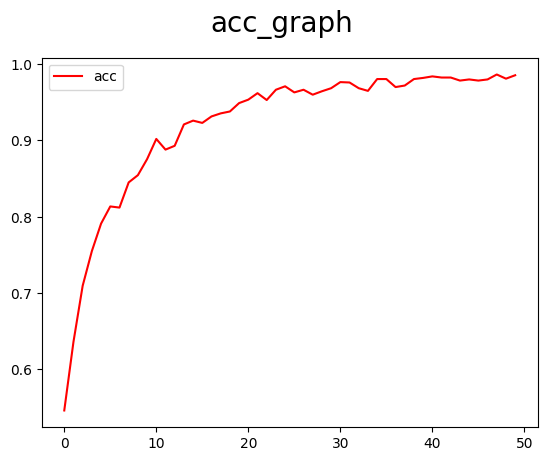

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()
#plt.plot(hist.history['val_accuracy'],color = 'orange',label = 'val_accs')
plt.plot(hist.history['accuracy'],color = 'red',label = 'acc')
fig.suptitle('acc_graph',fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

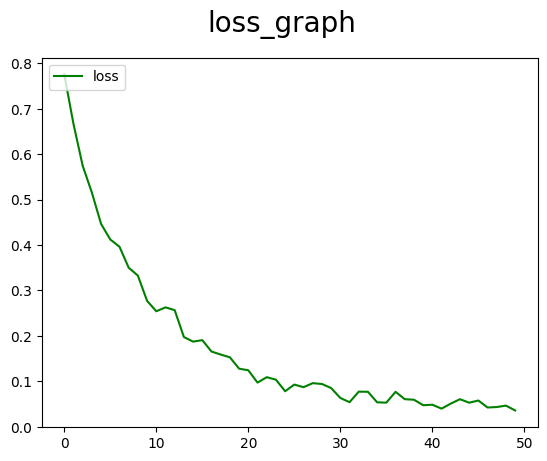

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(hist.history['loss'],color = 'green',label = 'loss')
#plt.plot(hist.history['val_loss'],color = 'cyan',label = 'val_loss')
fig.suptitle('loss_graph',fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [12]:
result = model.evaluate(X_test, y_test)


19/19 [==============================] - 3s 50ms/step - loss: 1.1288 - accuracy: 0.7767


1


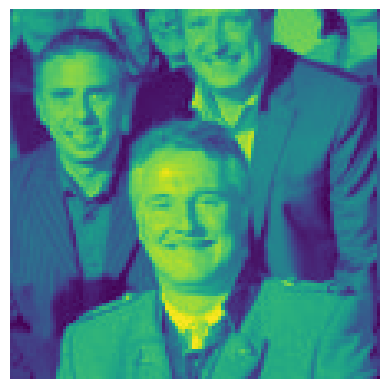

In [15]:
import numpy as np
import pandas as pd
# read csv file
df = pd.read_csv(r"/content/drive/MyDrive/112x112_2k_deepfake_images.csv")
# read pixels
images = np.array(df.iloc[:,1:])
labels = np.array(df.iloc[:,-1])
# select random number between 0 and 7172
index = 1222
# reshape 784 rows to 28 height x 28 width
sample_image = images[index,:].reshape(112,112)
# import plt for displaying image
from matplotlib import pyplot as plt
# plot image
plt.imshow(sample_image)
plt.axis('off')
# plot it's label
print(labels[index])
# save image
plt.savefig("./image{}_label{}".format(index,labels[index]))

In [ ]:
# Load libraries
from PIL import Image
import numpy as np

# Define the path to your image
image_path = r"C:\Users\Shivam\OneDrive\Desktop\0.jpg"
# Load the image using PIL
new_image = Image.open(image_path).convert("L")  # Convert to grayscale

# Resize the image to 28x28 pixels
new_image = new_image.resize((112, 112), Image.ANTIALIAS)

# Convert the image to a NumPy array
new_image = np.array(new_image)

# Reshape the image to match the model's input format
new_image = new_image.reshape(1, 112, 112, 1)

# Normalize the pixel values
new_image = new_image / 255.0


In [ ]:
prediction = model.predict(new_image)
predicted_digit = np.argmax(prediction)

print("Predicted digit:", predicted_digit)